In [6]:
import pandas as pd

# 加载数据
file_path = 'updated_all_issues_1.csv'  # 请替换为实际文件路径
data = pd.read_csv(file_path)

# 将 created_at 列转换为 datetime 格式
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')

# 去除无效的日期
data_cleaned = data[data['created_at'].notna()]

# 获取每个 slug 第一次出现的时间
first_times = data_cleaned.groupby('slug')['created_at'].min().reset_index()
first_times.rename(columns={'created_at': 'first_time'}, inplace=True)

# 将第一次出现时间合并到原数据
data_cleaned = pd.merge(data_cleaned, first_times, on='slug')

# 计算 created_at 和 first_time 之间的月份差异
data_cleaned['month_diff'] = (data_cleaned['created_at'].dt.year - data_cleaned['first_time'].dt.year) * 12 + (data_cleaned['created_at'].dt.month - data_cleaned['first_time'].dt.month)

# 过滤出 6 个月之内的数据（0-6 月）
data_cleaned = data_cleaned[data_cleaned['month_diff'] <= 6]

# 将 comments 列转换为数值类型（如果已经是数值类型则忽略）
data_cleaned['comments'] = pd.to_numeric(data_cleaned['comments'], errors='coerce').fillna(0)

# 格式化 cur_month 为 "YYYY-MM"
data_cleaned['cur_month'] = data_cleaned['created_at'].dt.to_period('M').dt.strftime('%Y-%m')

# 聚合每个 slug 和 cur_month 的评论数和 issue 数量
agg_data_cleaned = data_cleaned.groupby(['slug', 'first_time', 'cur_month']).agg(
    comments=('comments', 'sum'),
    amounts=('issue_number', 'count')
).reset_index()

# 计算每个月的索引（0 到 6）
agg_data_cleaned['index'] = (pd.to_datetime(agg_data_cleaned['cur_month']).dt.year - pd.to_datetime(agg_data_cleaned['first_time']).dt.year) * 12 + \
                            (pd.to_datetime(agg_data_cleaned['cur_month']).dt.month - pd.to_datetime(agg_data_cleaned['first_time']).dt.month)

# 创建包含所有 slugs 和月份（0-6）的数据框，确保每个 slug 都有 7 个月（即使某个月没有数据）
slug_months = pd.MultiIndex.from_product([data_cleaned['slug'].unique(), range(7)], names=['slug', 'index'])
all_months_data = pd.DataFrame(index=slug_months).reset_index()

# 将包含所有月份的空数据框与聚合数据合并
final_data = pd.merge(all_months_data, agg_data_cleaned, how='left', on=['slug', 'index'])

# 将 NaN 填充为 0（没有数据的月份）
final_data['comments'] = final_data['comments'].fillna(0)
final_data['amounts'] = final_data['amounts'].fillna(0)

# 确保即使没有数据的月份，仍然基于 'first_time' 计算 'cur_month'
final_data['cur_month'] = final_data.apply(
    lambda row: (pd.to_datetime(row['first_time']) + pd.DateOffset(months=row['index'])).strftime('%Y-%m'),
    axis=1
)

# 格式化 first_time 为 "YYYY-MM-DD"
final_data['first_time'] = pd.to_datetime(final_data['first_time'], errors='coerce').dt.strftime('%Y-%m-%d')

# 选择最终需要的列
final_output = final_data[['slug', 'first_time', 'cur_month', 'index', 'comments', 'amounts']]

# 保存结果为 CSV 文件
output_path = 'issue_out_1.csv'  # 请替换为你希望保存文件的路径
final_output.to_csv(output_path, index=False)

# 显示处理后的数据
final_output.head(20)


F:\anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


ValueError: NaTType does not support strftime

In [3]:
final_output.head(20)

,slug,first_time,cur_month,index,comments,amounts
0,100devs,2021-03-26,2021-03,0,0.0,1.0
1,100devs,2021-03-26,2021-04,1,14.0,60.0
2,100devs,2021-03-26,2021-05,2,1.0,1.0
3,100devs,2021-03-26,2021-06,3,0.0,20.0
4,100devs,2021-03-26,2021-07,4,0.0,1.0
5,100devs,2021-03-26,2021-08,5,4.0,6.0
6,100devs,NaN,NaT,6,0.0,0.0
7,24pullrequests,2013-12-27,2013-12,0,3.0,1.0
8,24pullrequests,NaN,NaT,1,0.0,0.0
9,24pullrequests,NaN,NaT,2,0.0,0.0


In [10]:
data2 = pd.read_csv('updated_issue_out.csv')
data2.head(20)

,slug,first_time,cur_month,index,comments,amounts
0,100devs,2021-03-26,2021-03,0,0.0,1.0
1,100devs,2021-03-26,2021-04,1,14.0,60.0
2,100devs,2021-03-26,2021-05,2,1.0,1.0
3,100devs,2021-03-26,2021-06,3,0.0,20.0
4,100devs,2021-03-26,2021-07,4,0.0,1.0
5,100devs,2021-03-26,2021-08,5,4.0,6.0
6,100devs,2021-03-26,NaT,6,0.0,0.0
7,24pullrequests,2013-12-27,2013-12,0,3.0,1.0
8,24pullrequests,2013-12-27,NaT,1,0.0,0.0
9,24pullrequests,2013-12-27,NaT,2,0.0,0.0


In [17]:
import pandas as pd

# 加载数据
file_path = 'updated_issue_out.csv'  # 请替换为实际文件路径
final_output = pd.read_csv(file_path)

# 确保 'first_time' 列是 datetime 类型
final_output['first_time'] = pd.to_datetime(final_output['first_time'], errors='coerce')

# 填充 'cur_month'，若其为 NaT，基于 'first_time' 和 'index' 计算
final_output['cur_month'] = final_output.apply(
    lambda row: (pd.to_datetime(row['first_time']) + pd.DateOffset(months=row['index'])).strftime('%Y-%m') 
    if True else row['cur_month'],
    axis=1
)

# 保存更新后的数据到新的 CSV 文件
output_path = 'final_fixed_issue_out.csv'  # 请替换为你希望保存文件的路径
final_output.to_csv(output_path, index=False)

# 显示更新后的数据
final_output.head(20)


,slug,first_time,cur_month,index,comments,amounts
0,100devs,2021-03-26,2021-03,0,0.0,1.0
1,100devs,2021-03-26,2021-04,1,14.0,60.0
2,100devs,2021-03-26,2021-05,2,1.0,1.0
3,100devs,2021-03-26,2021-06,3,0.0,20.0
4,100devs,2021-03-26,2021-07,4,0.0,1.0
5,100devs,2021-03-26,2021-08,5,4.0,6.0
6,100devs,2021-03-26,2021-09,6,0.0,0.0
7,24pullrequests,2013-12-27,2013-12,0,3.0,1.0
8,24pullrequests,2013-12-27,2014-01,1,0.0,0.0
9,24pullrequests,2013-12-27,2014-02,2,0.0,0.0


In [18]:
import pandas as pd

# 加载数据
file_path = 'final_with_new_rows.csv'  # 请替换为实际文件路径
final_output = pd.read_csv(file_path)


# 填充 'cur_month'，若其为 NaT，基于 'first_time' 和 'index' 计算
final_output['cur_month'] = final_output.apply(
    lambda row: (pd.to_datetime(row['first_time']) + pd.DateOffset(months=row['index'])).strftime('%Y-%m') 
    if True else row['cur_month'],
    axis=1
)

# 保存更新后的数据到新的 CSV 文件
output_path = 'final_fixed_issue_out.csv'  # 请替换为你希望保存文件的路径
final_output.to_csv(output_path, index=False)

# 显示更新后的数据
final_output.head(20)


,slug,first_time,cur_month,index,comments,amounts
0,100devs,2021-03-26,2021-03,0,0.0,1.0
1,100devs,2021-03-26,2021-04,1,14.0,60.0
2,100devs,2021-03-26,2021-05,2,1.0,1.0
3,100devs,2021-03-26,2021-06,3,0.0,20.0
4,100devs,2021-03-26,2021-07,4,0.0,1.0
5,100devs,2021-03-26,2021-08,5,4.0,6.0
6,100devs,2021-03-26,2021-09,6,0.0,0.0
7,24pullrequests,2013-12-27,2013-12,0,3.0,1.0
8,24pullrequests,2013-12-27,2014-01,1,0.0,0.0
9,24pullrequests,2013-12-27,2014-02,2,0.0,0.0


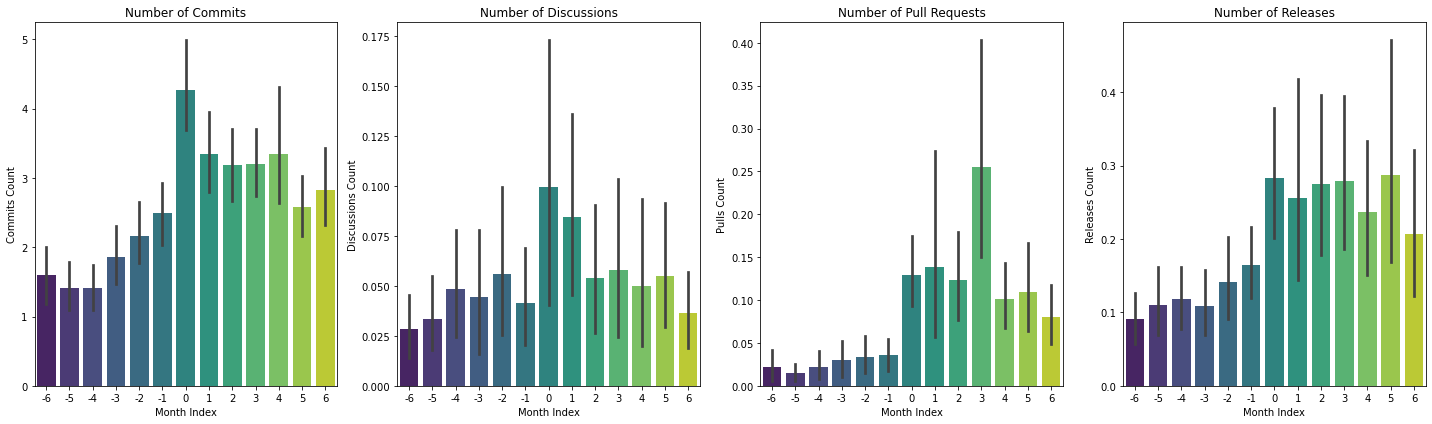

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot for each metric: commits, discussions, pulls, and releases
file_path = 'all_merged_data.csv'  # Replace this with the actual file path
final_merged_data = pd.read_csv(file_path)

# Set up the figure for the multiple bar plots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Bar plot for commits_count
sns.barplot(data=final_merged_data, x='index', y='commits_count', ax=axes[0], palette="viridis")
axes[0].set_title('Number of Commits')
axes[0].set_xlabel('Month Index')
axes[0].set_ylabel('Commits Count')

# Bar plot for discussions_count
sns.barplot(data=final_merged_data, x='index', y='discussions_count', ax=axes[1], palette="viridis")
axes[1].set_title('Number of Discussions')
axes[1].set_xlabel('Month Index')
axes[1].set_ylabel('Discussions Count')

# Bar plot for pulls_count
sns.barplot(data=final_merged_data, x='index', y='pulls_count', ax=axes[2], palette="viridis")
axes[2].set_title('Number of Pull Requests')
axes[2].set_xlabel('Month Index')
axes[2].set_ylabel('Pulls Count')

# Bar plot for releases_count
sns.barplot(data=final_merged_data, x='index', y='releases_count', ax=axes[3], palette="viridis")
axes[3].set_title('Number of Releases')
axes[3].set_xlabel('Month Index')
axes[3].set_ylabel('Releases Count')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# 合并图像
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap



def generate_boxplot(file_path, value_name, preprocess, ax):
    # 读取CSV文件
    file_path = 'all_merged_data.csv'
    df = pd.read_csv(file_path)
    

    
    # 将数据转换为适合绘图的格式
    df_melted = df.melt(id_vars=['slug'], var_name='index', value_name=value_name)
    
    
    # # 对 value_name 取对数
    df_melted[f'{value_name}(Count)'] = np.log1p(df_melted[value_name])
    # df_melted[f'{value_name}(Count)'] = df_melted[value_name]
    if value_name != 'Spend_Count':
        df_melted = df_melted.loc[df_melted[f'{value_name}(Count)'] > 0]
        

    # df_melted.boxplot(column=f'{value_name}(Count)', by='Period', ax=ax , grid=False, flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, whis=1.5, widths=0.65)
    
    for box, color in zip(ax.boxplot(df_melted[f'{value_name}(Count)'].groupby(df_melted['Period']).apply(list), patch_artist=True, flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, whis=1.5, widths=0.65)['boxes'], colors):
        box.set_facecolor(color)
    
    # 设置xlabel
    if value_name == 'Commit_Count':
        # ax.set_ylabel('commit数（log）')
        ax.set_ylabel('number of commits（log）')
    elif value_name == 'Issue_Count':
        # ax.set_ylabel('issue数（log）')
        ax.set_ylabel('number of issues（log）')
    else:
        # ax.set_ylabel('支出次数（log）')
        ax.set_ylabel('number of spending（log）')
    # ax.set_xlabel('周期（月）')
    ax.set_xlabel('month index')
    if value_name == 'Commit_Count':
        ax.set_title('(a)', y=-0.2)
    elif value_name == 'Issue_Count':
        ax.set_title('(b)', y=-0.2)
    else:
        ax.set_title('(c)', y=-0.2)
    
    ax.axvspan(6.675, 7.325, color='grey', alpha=0.3)
    
    # 设置ylim
    if value_name == 'Spend_Count':
        ax.set_ylim(top=4.5)

def generate_colors(n, saturation=0.5):
    # cmap = LinearSegmentedColormap.from_list('custom_cmap', [start_color, end_color], N=n)
    # return [cmap(i) for i in range(cmap.N)]
    hsv_colors = plt.cm.hsv(np.linspace(0, 1, n))
    hsv_colors[:, 3] = saturation
    print(hsv_colors)
    return hsv_colors

fig, axs = plt.subplots(1, 3, figsize=(17, 5))

ax1, ax2, ax3 = axs.flatten()

# 自定义中线样式
medianprops = dict(linewidth=2.5, color='black')

# 彩色图
# start_color = '#a02424'  # 番茄红
# end_color = '#b4297e'    # 钢蓝色
n = 13
colors = generate_colors(n)

# 自定义箱型图样式
boxprops = dict(color='black')

# 自定义须样式
whiskerprops = dict(color='black')

# 不显示离群点
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# plt.rcParams['font.family'] = ['Times New Roman','SimSun']

generate_boxplot('../data/commit_info.csv', 'Commit_Count', preprocess_commit, ax1)
generate_boxplot('../data/issue_info.csv', 'Issue_Count', preprocess_issue, ax2)
generate_boxplot('../data/spend_info.csv', 'Spend_Count', preprocess_spend, ax3)

plt.suptitle('', fontsize=16)

# 自动调整子图参数
plt.tight_layout(w_pad=3)

# 保存图表
plt.savefig('../graph/merged_boxplot_en.png')

# 保存为svg
plt.savefig('../graph/merged_boxplot_en.svg')

# 保存为pdf
plt.savefig('../graph/merged_boxplot_en.pdf')

# 显示图表
plt.show()



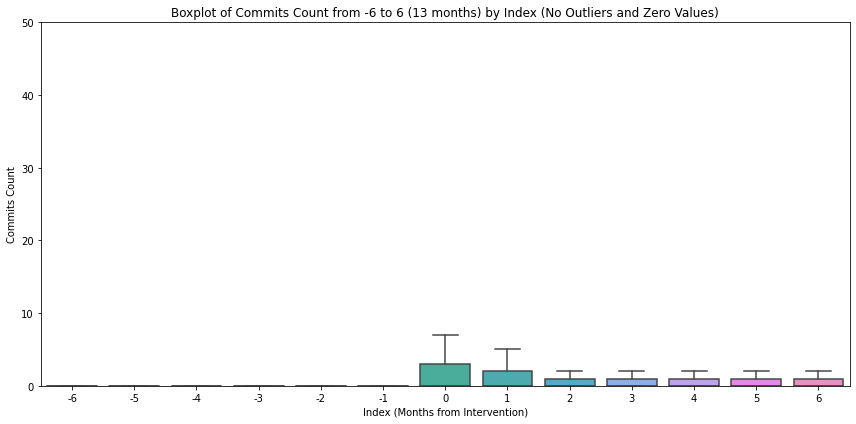

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'all_merged_data.csv'  # 替换为你的文件路径
all_merged_data = pd.read_csv(file_path)

# 过滤数据，确保 index 在 -6 到 6 之间
filtered_data = all_merged_data[(all_merged_data['index'] >= -6) & (all_merged_data['index'] <= 6)]

# 排除 commits_count 为 0 的数据
filtered_data_non_zero = filtered_data

# 创建箱型图，排除离群点
fig, ax = plt.subplots(figsize=(12, 6))

# 设置不显示离群点（flierprops）
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# 绘制箱型图
sns.boxplot(data=filtered_data_non_zero, x='index', y='commits_count', ax=ax, flierprops=flierprops)

# 设置标题和标签
ax.set_title('Boxplot of Commits Count from -6 to 6 (13 months) by Index (No Outliers and Zero Values)')
ax.set_xlabel('Index (Months from Intervention)')
ax.set_ylabel('Commits Count')

# 设置纵坐标范围
ax.set_ylim(0, 50)

# 显示图表
plt.tight_layout()
plt.show()


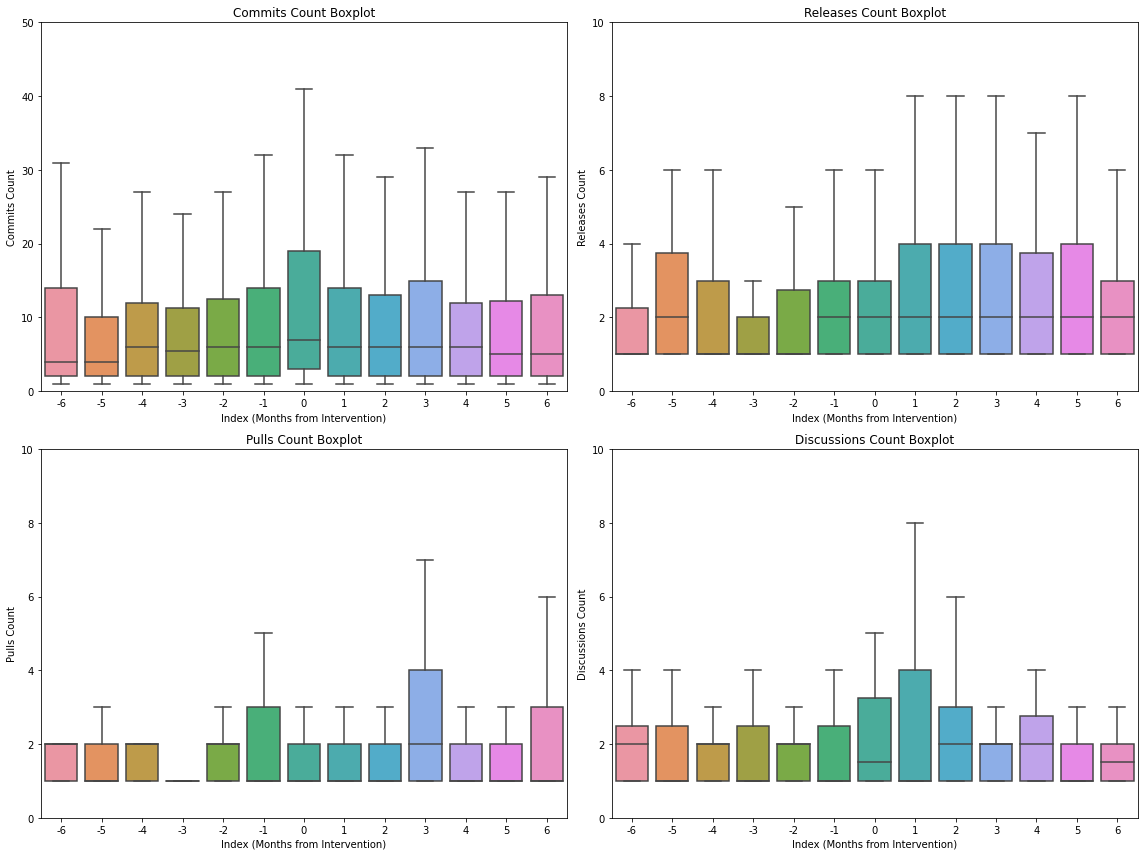

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'all_merged_data.csv'  # 替换为你的文件路径
all_merged_data = pd.read_csv(file_path)

# 过滤数据，确保 index 在 -6 到 6 之间
filtered_data = all_merged_data[(all_merged_data['index'] >= -6) & (all_merged_data['index'] <= 6)]

# 创建 4 张箱型图的子图
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2 行 2 列的子图

# 自定义不显示离群点
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# 绘制 commits_count 的箱型图，排除 commits_count 为 0 的数据
filtered_commits = filtered_data[filtered_data['commits_count'] > 0]
sns.boxplot(data=filtered_commits, x='index', y='commits_count', ax=axs[0, 0], flierprops=flierprops)
axs[0, 0].set_title('Commits Count Boxplot')
axs[0, 0].set_xlabel('Index (Months from Intervention)')
axs[0, 0].set_ylabel('Commits Count')
axs[0, 0].set_ylim(0, 50)

# 绘制 releases_count 的箱型图，排除 releases_count 为 0 的数据
filtered_releases = filtered_data[filtered_data['releases_count'] > 0]
sns.boxplot(data=filtered_releases, x='index', y='releases_count', ax=axs[0, 1], flierprops=flierprops)
axs[0, 1].set_title('Releases Count Boxplot')
axs[0, 1].set_xlabel('Index (Months from Intervention)')
axs[0, 1].set_ylabel('Releases Count')
axs[0, 1].set_ylim(0, 10)

# 绘制 pulls_count 的箱型图，排除 pulls_count 为 0 的数据
filtered_pulls = filtered_data[filtered_data['pulls_count'] > 0]
sns.boxplot(data=filtered_pulls, x='index', y='pulls_count', ax=axs[1, 0], flierprops=flierprops)
axs[1, 0].set_title('Pulls Count Boxplot')
axs[1, 0].set_xlabel('Index (Months from Intervention)')
axs[1, 0].set_ylabel('Pulls Count')
axs[1, 0].set_ylim(0, 10)

# 绘制 discussions_count 的箱型图，排除 discussions_count 为 0 的数据
filtered_discussions = filtered_data[filtered_data['discussions_count'] > 0]
sns.boxplot(data=filtered_discussions, x='index', y='discussions_count', ax=axs[1, 1], flierprops=flierprops)
axs[1, 1].set_title('Discussions Count Boxplot')
axs[1, 1].set_xlabel('Index (Months from Intervention)')
axs[1, 1].set_ylabel('Discussions Count')
axs[1, 1].set_ylim(0, 10)

# 自动调整子图参数，使图表不重叠
plt.tight_layout()

# 显示图表
plt.show()


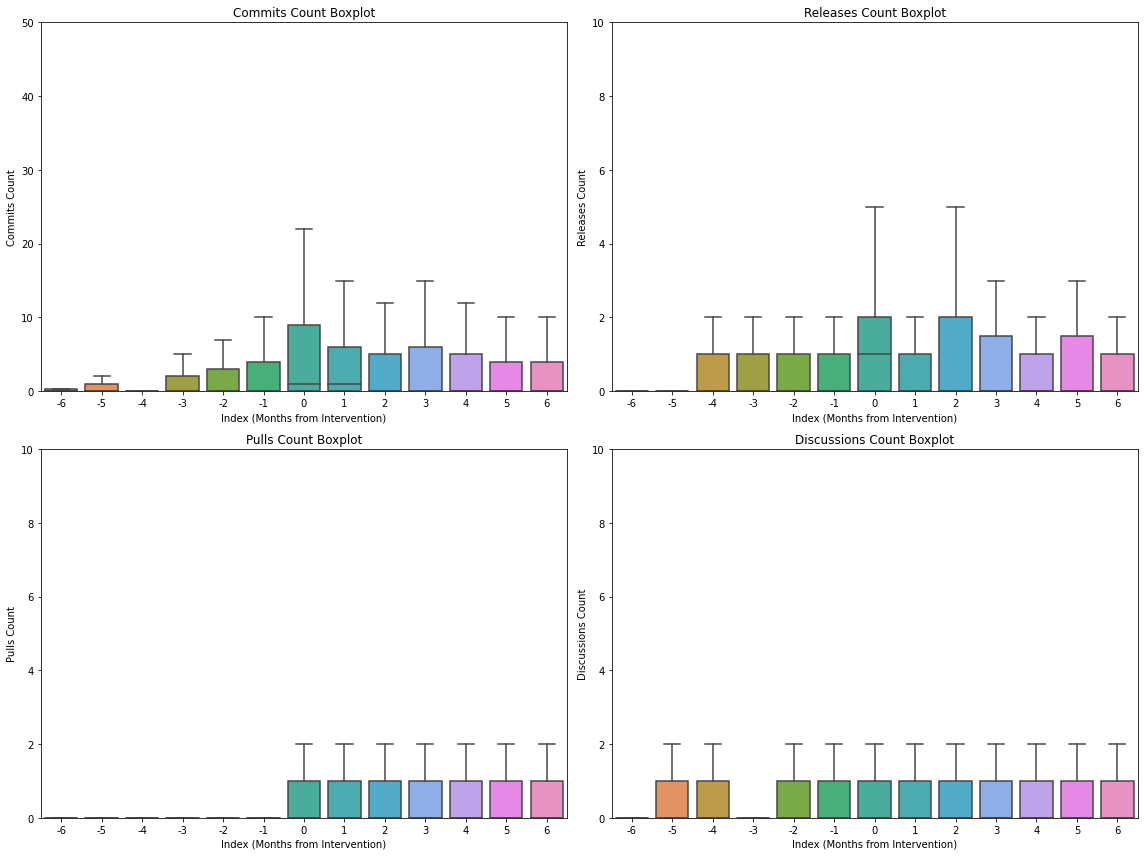

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'all_merged_data.csv'  # 替换为你的文件路径
all_merged_data = pd.read_csv(file_path)

# 过滤数据，确保 index 在 -6 到 6 之间
filtered_data = all_merged_data[(all_merged_data['index'] >= -6) & (all_merged_data['index'] <= 6)]

# 排除在某个 slug 上所有 index 的 commits_count 为 0 的数据
# 对于每个 slug，检查是否所有 index 上的 commits_count 都为 0，如果是则排除该 slug 的数据
filtered_data_commits = filtered_data.groupby('slug').filter(lambda x: (x['commits_count'] != 0).any())

# 排除在某个 slug 上所有 index 的 releases_count 为 0 的数据
filtered_data_releases = filtered_data.groupby('slug').filter(lambda x: (x['releases_count'] != 0).any())

# 排除在某个 slug 上所有 index 的 pulls_count 为 0 的数据
filtered_data_pulls = filtered_data.groupby('slug').filter(lambda x: (x['pulls_count'] != 0).any())

# 排除在某个 slug 上所有 index 的 discussions_count 为 0 的数据
filtered_data_discussions = filtered_data.groupby('slug').filter(lambda x: (x['discussions_count'] != 0).any())

# 创建 4 张箱型图的子图
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2 行 2 列的子图

# 自定义不显示离群点
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# 绘制 commits_count 的箱型图
sns.boxplot(data=filtered_data_commits, x='index', y='commits_count', ax=axs[0, 0], flierprops=flierprops)
axs[0, 0].set_title('Commits Count Boxplot')
axs[0, 0].set_xlabel('Index (Months from Intervention)')
axs[0, 0].set_ylabel('Commits Count')
axs[0, 0].set_ylim(0, 50)

# 绘制 releases_count 的箱型图
sns.boxplot(data=filtered_data_releases, x='index', y='releases_count', ax=axs[0, 1], flierprops=flierprops)
axs[0, 1].set_title('Releases Count Boxplot')
axs[0, 1].set_xlabel('Index (Months from Intervention)')
axs[0, 1].set_ylabel('Releases Count')
axs[0, 1].set_ylim(0, 10)

# 绘制 pulls_count 的箱型图
sns.boxplot(data=filtered_data_pulls, x='index', y='pulls_count', ax=axs[1, 0], flierprops=flierprops)
axs[1, 0].set_title('Pulls Count Boxplot')
axs[1, 0].set_xlabel('Index (Months from Intervention)')
axs[1, 0].set_ylabel('Pulls Count')
axs[1, 0].set_ylim(0, 10)

# 绘制 discussions_count 的箱型图
sns.boxplot(data=filtered_data_discussions, x='index', y='discussions_count', ax=axs[1, 1], flierprops=flierprops)
axs[1, 1].set_title('Discussions Count Boxplot')
axs[1, 1].set_xlabel('Index (Months from Intervention)')
axs[1, 1].set_ylabel('Discussions Count')
axs[1, 1].set_ylim(0, 10)

# 自动调整子图参数，使图表不重叠
plt.tight_layout()

# 显示图表
plt.show()


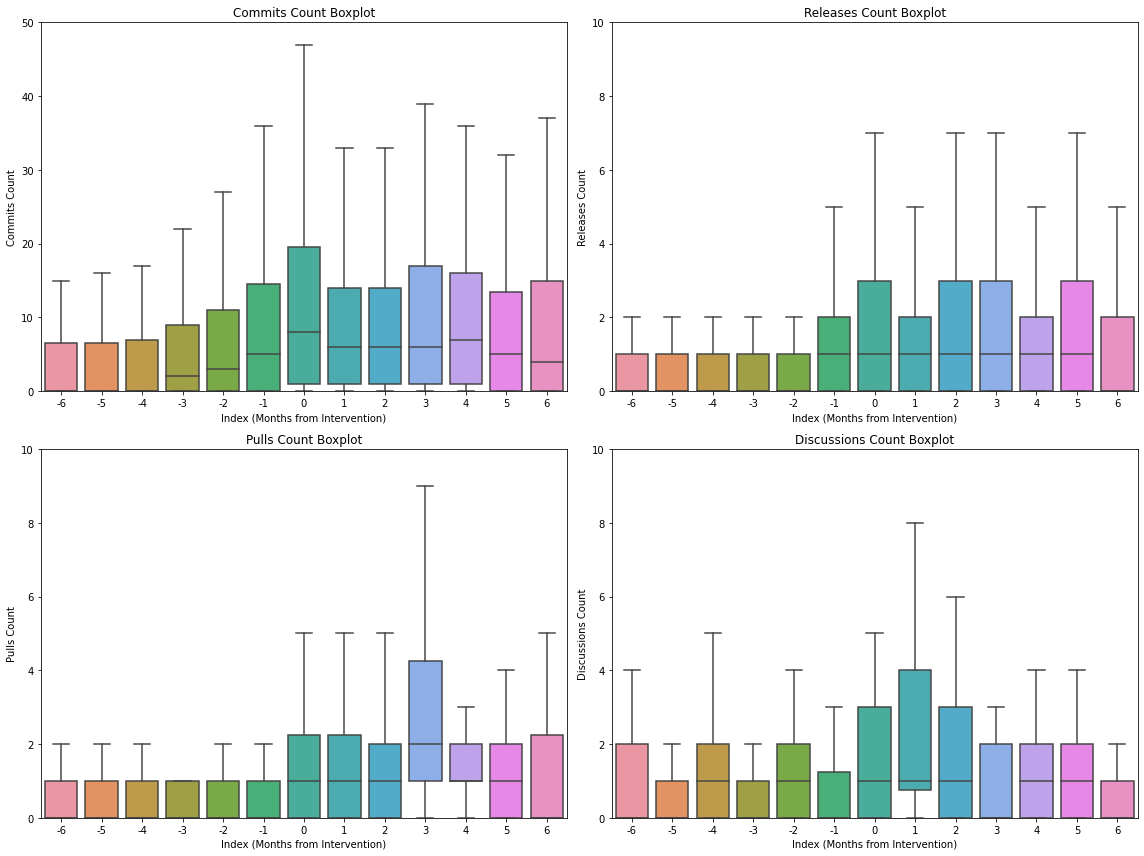

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'all_merged_data_with_flags.csv'
all_merged_data = pd.read_csv(file_path)

# 过滤 index 在 -6 到 6 之间
filtered_data = all_merged_data[(all_merged_data['index'] >= -6) & (all_merged_data['index'] <= 6)]

# 过滤 commits_count：至少一个非零且总和 > 3
filtered_data_commits = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['commits_count'] != 0).any() and x['commits_count'].sum() > 50)
)

# 过滤 releases_count：至少一个非零且总和 > 2
filtered_data_releases = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['releases_count'] != 0).any() and x['releases_count'].sum() > 5)
)

# 过滤 pulls_count：至少一个非零且总和 > 1
filtered_data_pulls = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['pulls_count'] != 0).any() and x['pulls_count'].sum() > 5)
)

# 过滤 discussions_count：至少一个非零且总和 > 0
filtered_data_discussions = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['discussions_count'] != 0).any() and x['discussions_count'].sum() > 5)
)

# 创建 4 张箱型图的子图
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 不显示离群点
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# commits_count 箱型图
sns.boxplot(data=filtered_data_commits, x='index', y='commits_count', ax=axs[0, 0], flierprops=flierprops)
axs[0, 0].set_title('Commits Count Boxplot')
axs[0, 0].set_xlabel('Index (Months from Intervention)')
axs[0, 0].set_ylabel('Commits Count')
axs[0, 0].set_ylim(0, 50)

# releases_count 箱型图
sns.boxplot(data=filtered_data_releases, x='index', y='releases_count', ax=axs[0, 1], flierprops=flierprops)
axs[0, 1].set_title('Releases Count Boxplot')
axs[0, 1].set_xlabel('Index (Months from Intervention)')
axs[0, 1].set_ylabel('Releases Count')
axs[0, 1].set_ylim(0, 10)

# pulls_count 箱型图
sns.boxplot(data=filtered_data_pulls, x='index', y='pulls_count', ax=axs[1, 0], flierprops=flierprops)
axs[1, 0].set_title('Pulls Count Boxplot')
axs[1, 0].set_xlabel('Index (Months from Intervention)')
axs[1, 0].set_ylabel('Pulls Count')
axs[1, 0].set_ylim(0, 10)

# discussions_count 箱型图
sns.boxplot(data=filtered_data_discussions, x='index', y='discussions_count', ax=axs[1, 1], flierprops=flierprops)
axs[1, 1].set_title('Discussions Count Boxplot')
axs[1, 1].set_xlabel('Index (Months from Intervention)')
axs[1, 1].set_ylabel('Discussions Count')
axs[1, 1].set_ylim(0, 10)

# 调整子图布局
plt.tight_layout()
plt.show()


原始 slug 总数: 1016
满足 commits_count 条件的 slug 数量: 195
满足 releases_count 条件的 slug 数量: 74
满足 pulls_count 条件的 slug 数量: 44
满足 discussions_count 条件的 slug 数量: 30


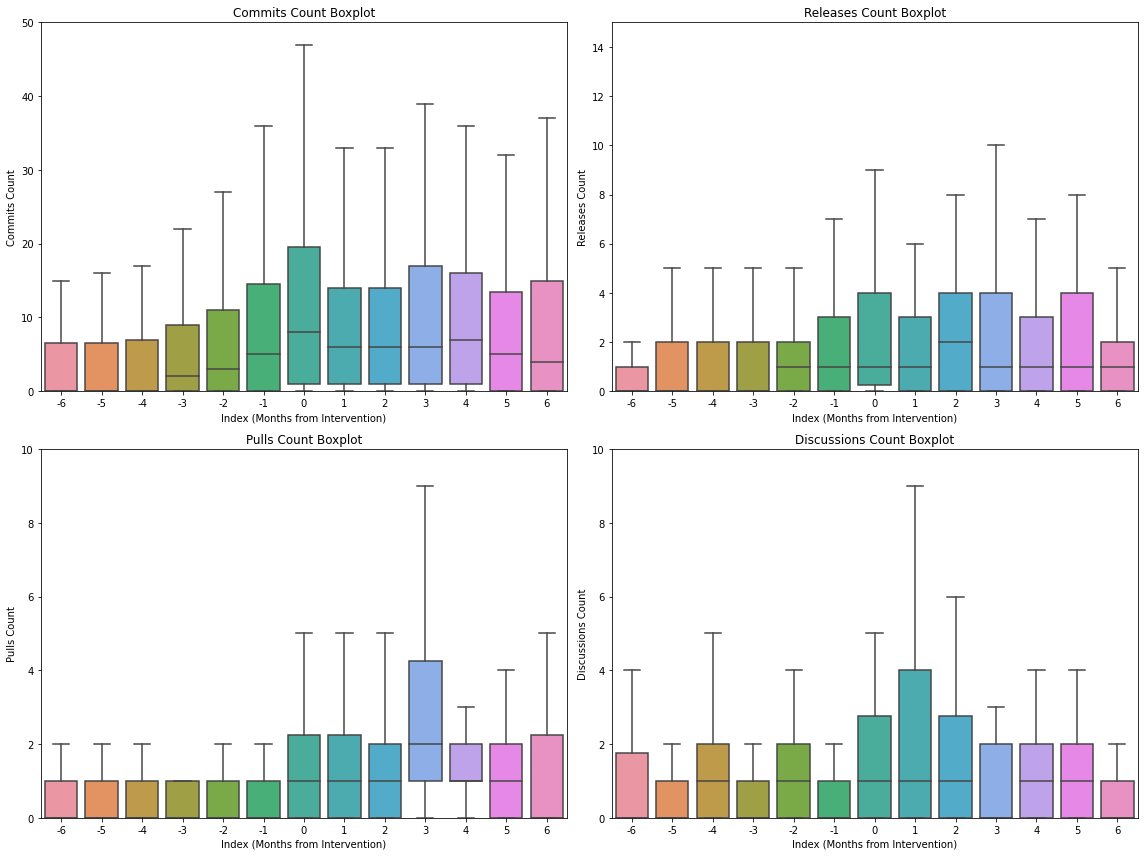

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'all_merged_data_with_flags.csv'
all_merged_data = pd.read_csv(file_path)

# 输出原始 slug 数量
original_slug_count = all_merged_data['slug'].nunique()
print(f"原始 slug 总数: {original_slug_count}")

# 过滤 index 在 -6 到 6 之间
filtered_data = all_merged_data[(all_merged_data['index'] >= -6) & (all_merged_data['index'] <= 6)]

# 过滤 commits_count：至少一个非零且总和 > 50
filtered_data_commits = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['commits_count'] != 0).any() and x['commits_count'].sum() > 50)
)
print(f"满足 commits_count 条件的 slug 数量: {filtered_data_commits['slug'].nunique()}")

# 过滤 releases_count：至少一个非零且总和 > 10
filtered_data_releases = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['releases_count'] != 0).any() and x['releases_count'].sum() > 10)  
)
print(f"满足 releases_count 条件的 slug 数量: {filtered_data_releases['slug'].nunique()}")

# 过滤 pulls_count：至少一个非零且总和 > 5
filtered_data_pulls = (
    filtered_data.groupby('slug') 
    .filter(lambda x: (x['pulls_count'] != 0).any() and x['pulls_count'].sum() > 5)
)
print(f"满足 pulls_count 条件的 slug 数量: {filtered_data_pulls['slug'].nunique()}")

# 过滤 discussions_count：至少一个非零且总和 > 5
filtered_data_discussions = (
    filtered_data.groupby('slug')
    .filter(lambda x: (x['discussions_count'] != 0).any() and x['discussions_count'].sum() > 5)
)
print(f"满足 discussions_count 条件的 slug 数量: {filtered_data_discussions['slug'].nunique()}")

# 创建 4 张箱型图的子图
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 不显示离群点
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# commits_count 箱型图
sns.boxplot(data=filtered_data_commits, x='index', y='commits_count', ax=axs[0, 0], flierprops=flierprops)
axs[0, 0].set_title('Commits Count Boxplot')
axs[0, 0].set_xlabel('Index (Months from Intervention)')
axs[0, 0].set_ylabel('Commits Count')
axs[0, 0].set_ylim(0, 50)

# releases_count 箱型图
sns.boxplot(data=filtered_data_releases, x='index', y='releases_count', ax=axs[0, 1], flierprops=flierprops)
axs[0, 1].set_title('Releases Count Boxplot')
axs[0, 1].set_xlabel('Index (Months from Intervention)')
axs[0, 1].set_ylabel('Releases Count')
axs[0, 1].set_ylim(0, 15)

# pulls_count 箱型图
sns.boxplot(data=filtered_data_pulls, x='index', y='pulls_count', ax=axs[1, 0], flierprops=flierprops)
axs[1, 0].set_title('Pulls Count Boxplot')
axs[1, 0].set_xlabel('Index (Months from Intervention)')
axs[1, 0].set_ylabel('Pulls Count')
axs[1, 0].set_ylim(0, 10)

# discussions_count 箱型图
sns.boxplot(data=filtered_data_discussions, x='index', y='discussions_count', ax=axs[1, 1], flierprops=flierprops)
axs[1, 1].set_title('Discussions Count Boxplot')
axs[1, 1].set_xlabel('Index (Months from Intervention)')
axs[1, 1].set_ylabel('Discussions Count')
axs[1, 1].set_ylim(0, 10)

# 调整子图布局
plt.tight_layout()
plt.savefig("boxplots.pdf")
plt.show()


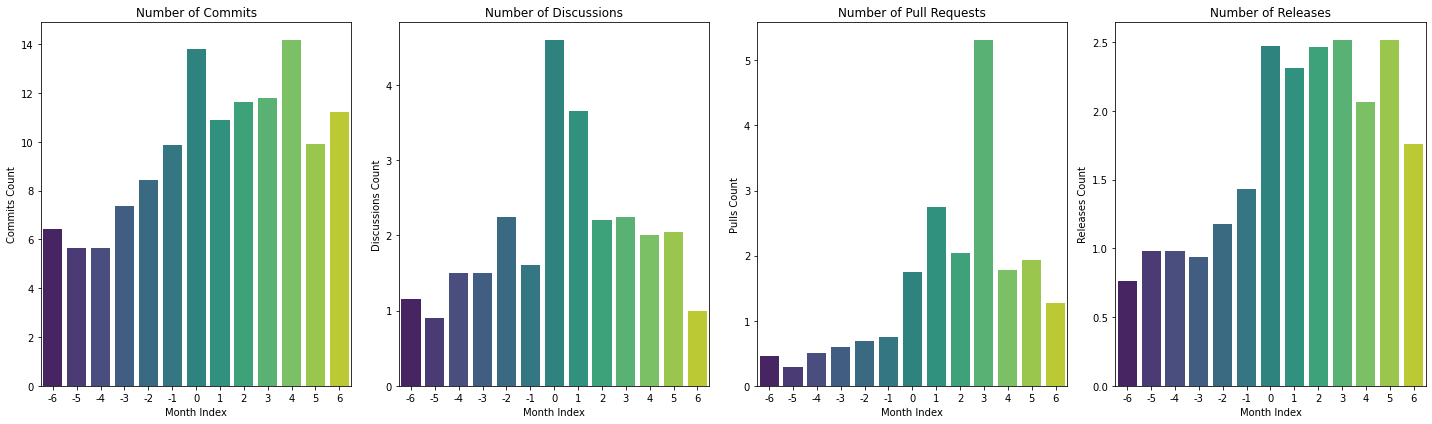

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
file_path = 'all_merged_data.csv'
final_merged_data = pd.read_csv(file_path)

# 过滤 index 在 -6 到 6 之间
filtered_data = final_merged_data[(final_merged_data['index'] >= -6) & (final_merged_data['index'] <= 6)]

# 各行为的 slug 过滤（按自定义阈值）
filtered_commits = filtered_data.groupby('slug').filter(
    lambda x: (x['commits_count'] != 0).any() and x['commits_count'].sum() > 50
)
filtered_discussions = filtered_data.groupby('slug').filter(
    lambda x: (x['discussions_count'] != 0).any() and x['discussions_count'].sum() > 10
)
filtered_pulls = filtered_data.groupby('slug').filter(
    lambda x: (x['pulls_count'] != 0).any() and x['pulls_count'].sum() > 5
)
filtered_releases = filtered_data.groupby('slug').filter(
    lambda x: (x['releases_count'] != 0).any() and x['releases_count'].sum() > 5
)

# 创建图像
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# 使用 np.sum 作为 estimator，使用 ci=None 来禁用误差线
sns.barplot(data=filtered_commits, x='index', y='commits_count', ax=axes[0], palette="viridis", estimator=np.mean, ci=None)
axes[0].set_title('Number of Commits')
axes[0].set_xlabel('Month Index')
axes[0].set_ylabel('Commits Count')

sns.barplot(data=filtered_discussions, x='index', y='discussions_count', ax=axes[1], palette="viridis", estimator=np.mean, ci=None)
axes[1].set_title('Number of Discussions')
axes[1].set_xlabel('Month Index')
axes[1].set_ylabel('Discussions Count')

sns.barplot(data=filtered_pulls, x='index', y='pulls_count', ax=axes[2], palette="viridis", estimator=np.mean, ci=None)
axes[2].set_title('Number of Pull Requests')
axes[2].set_xlabel('Month Index')
axes[2].set_ylabel('Pulls Count')

sns.barplot(data=filtered_releases, x='index', y='releases_count', ax=axes[3], palette="viridis", estimator=np.mean, ci=None)
axes[3].set_title('Number of Releases')
axes[3].set_xlabel('Month Index')
axes[3].set_ylabel('Releases Count')

plt.tight_layout()
plt.show()


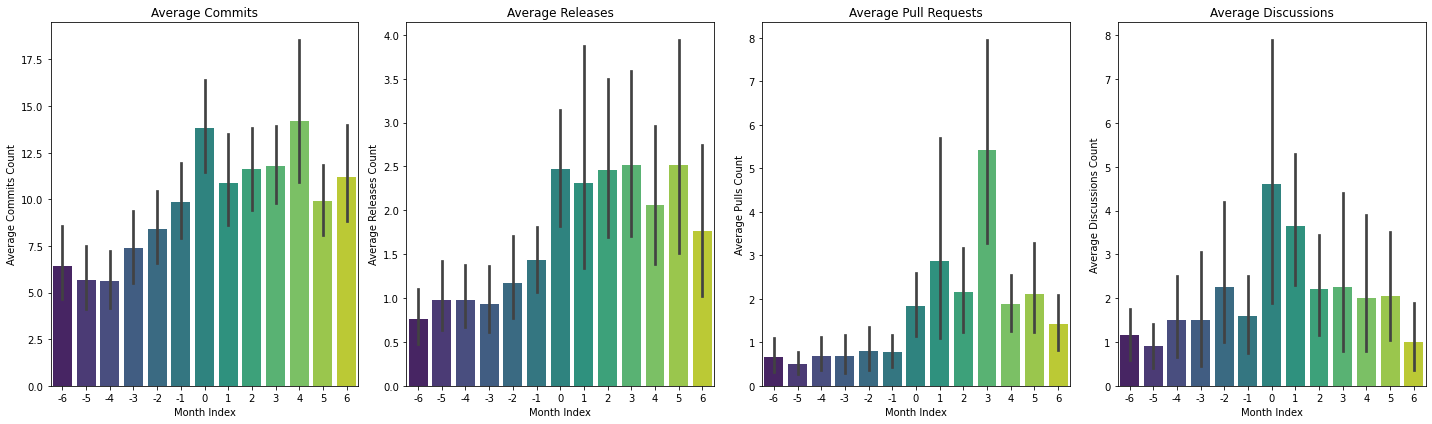

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
file_path = 'all_merged_data_with_flags.csv'
final_merged_data = pd.read_csv(file_path)

# 过滤 index 在 -6 到 6 之间
filtered_data = final_merged_data[(final_merged_data['index'] >= -6) & (final_merged_data['index'] <= 6)]

# 各行为的 slug 过滤（按自定义阈值）
filtered_commits = filtered_data.groupby('slug').filter(
    lambda x: (x['commits_count'] != 0).any() and x['commits_count'].sum() > 50
)
filtered_discussions = filtered_data.groupby('slug').filter(
    lambda x: (x['discussions_count'] != 0).any() and x['discussions_count'].sum() > 10
)
filtered_pulls = filtered_data.groupby('slug').filter(
    lambda x: (x['pulls_count'] != 0).any() and x['pulls_count'].sum() > 5
)
filtered_releases = filtered_data.groupby('slug').filter(
    lambda x: (x['releases_count'] != 0).any() and x['releases_count'].sum() > 5
)

# 创建图像
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# 使用 np.mean 作为 estimator，ci=None 关闭误差线
sns.barplot(data=filtered_commits, x='index', y='commits_count', ax=axes[0], palette="viridis", estimator=np.mean)
axes[0].set_title('Average Commits')
axes[0].set_xlabel('Month Index')
axes[0].set_ylabel('Average Commits Count')

sns.barplot(data=filtered_releases, x='index', y='releases_count', ax=axes[1], palette="viridis", estimator=np.mean)
axes[1].set_title('Average Releases')
axes[1].set_xlabel('Month Index')
axes[1].set_ylabel('Average Releases Count')

sns.barplot(data=filtered_pulls, x='index', y='pulls_count', ax=axes[2], palette="viridis", estimator=np.mean)
axes[2].set_title('Average Pull Requests')
axes[2].set_xlabel('Month Index')
axes[2].set_ylabel('Average Pulls Count')

sns.barplot(data=filtered_discussions, x='index', y='discussions_count', ax=axes[3], palette="viridis", estimator=np.mean)
axes[3].set_title('Average Discussions')
axes[3].set_xlabel('Month Index')
axes[3].set_ylabel('Average Discussions Count')

plt.tight_layout()
plt.show()


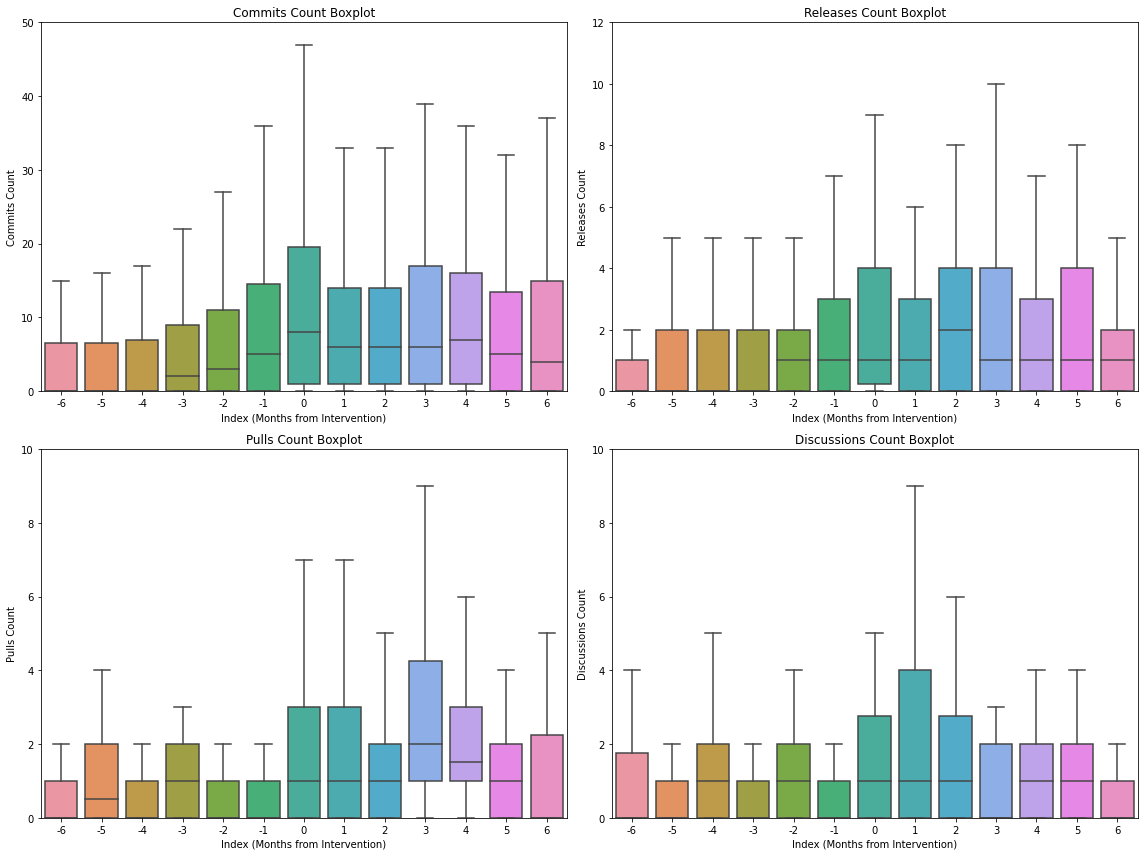

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 分别读取每个行为指标对应的 CSV 文件
filtered_data_commits = pd.read_csv('new_filtered_commits.csv')
filtered_data_releases = pd.read_csv('new_filtered_releases.csv')
filtered_data_pulls = pd.read_csv('new_filtered_pulls.csv')
filtered_data_discussions = pd.read_csv('new_filtered_discussions.csv')

# 创建 4 张箱型图的子图
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 不显示离群点
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# commits_count 箱型图
sns.boxplot(data=filtered_data_commits, x='index', y='commits_count', ax=axs[0, 0], flierprops=flierprops)
axs[0, 0].set_title('Commits Count Boxplot')
axs[0, 0].set_xlabel('Index (Months from Intervention)')
axs[0, 0].set_ylabel('Commits Count')
axs[0, 0].set_ylim(0, 50)

# releases_count 箱型图
sns.boxplot(data=filtered_data_releases, x='index', y='releases_count', ax=axs[0, 1], flierprops=flierprops)
axs[0, 1].set_title('Releases Count Boxplot')
axs[0, 1].set_xlabel('Index (Months from Intervention)')
axs[0, 1].set_ylabel('Releases Count')
axs[0, 1].set_ylim(0, 12)

# pulls_count 箱型图
sns.boxplot(data=filtered_data_pulls, x='index', y='pulls_count', ax=axs[1, 0], flierprops=flierprops)
axs[1, 0].set_title('Pulls Count Boxplot')
axs[1, 0].set_xlabel('Index (Months from Intervention)')
axs[1, 0].set_ylabel('Pulls Count')
axs[1, 0].set_ylim(0, 10)

# discussions_count 箱型图
sns.boxplot(data=filtered_data_discussions, x='index', y='discussions_count', ax=axs[1, 1], flierprops=flierprops)
axs[1, 1].set_title('Discussions Count Boxplot')
axs[1, 1].set_xlabel('Index (Months from Intervention)')
axs[1, 1].set_ylabel('Discussions Count')
axs[1, 1].set_ylim(0, 10)

# 调整子图布局
plt.tight_layout()
plt.savefig("boxplots_1.pdf")
plt.show()


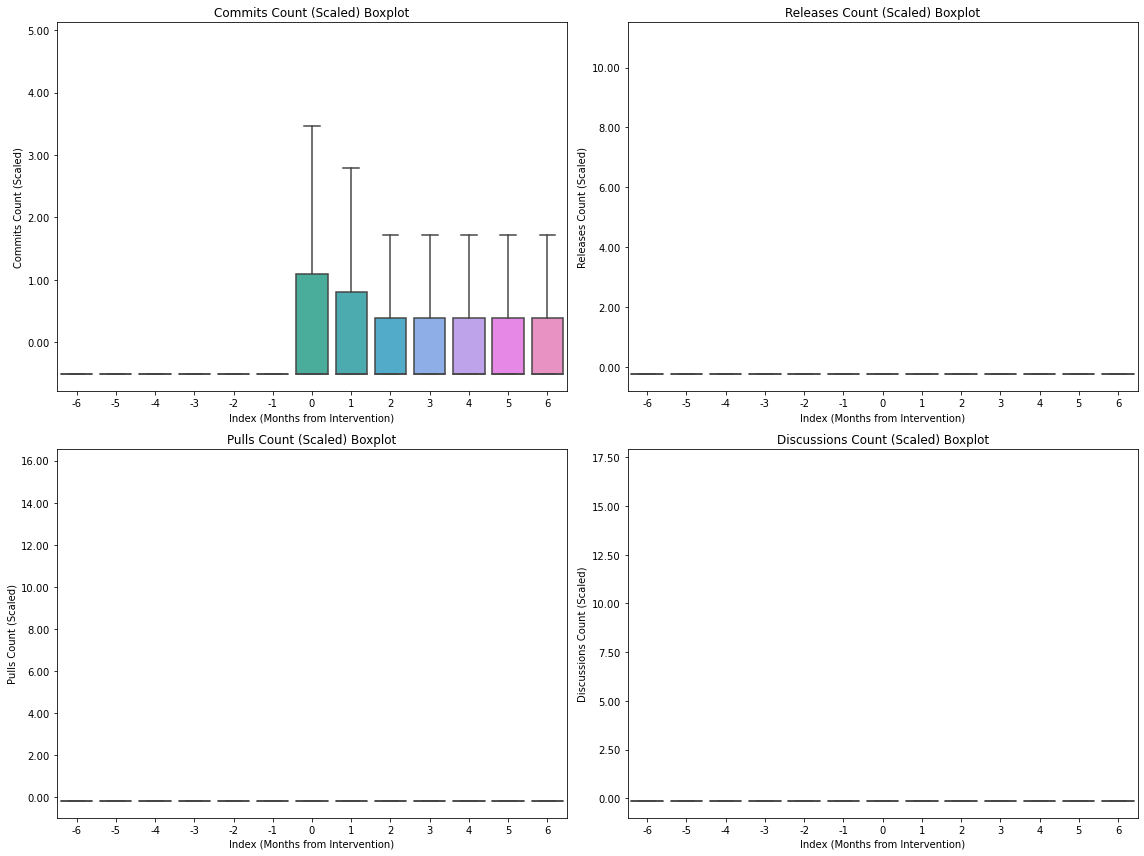

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# 读取CSV文件
file_path = 'Full_Dataset_with_Amounts_Scaled.csv'  # 替换为你的实际路径
all_merged_data = pd.read_csv(file_path)

# 仅过滤 index 在 -6 到 6 之间的数据
filtered_data = all_merged_data[(all_merged_data['index'] >= -6) & (all_merged_data['index'] <= 6)]

# 创建 2x2 子图区域
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
flierprops = dict(marker='o', color='w', markerfacecolor='w', alpha=0)

# 映射列名与图形信息
plot_info = [
    ('commits_count_scaled', 'Commits Count (Scaled)', axs[0, 0]),
    ('releases_count_scaled', 'Releases Count (Scaled)', axs[0, 1]),
    ('pulls_count_scaled', 'Pulls Count (Scaled)', axs[1, 0]),
    ('discussions_count_scaled', 'Discussions Count (Scaled)', axs[1, 1]),
]

# 绘图
for col, title, ax in plot_info:
    sns.boxplot(data=filtered_data, x='index', y=col, ax=ax, flierprops=flierprops)
    ax.set_title(f'{title} Boxplot')
    ax.set_xlabel('Index (Months from Intervention)')
    ax.set_ylabel(title)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # y轴设置为两位小数

# 布局调整
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
from scipy.stats import wilcoxon

# 读取数据
file_path = 'Full_Dataset_with_Amounts_Scaled.csv'
df = pd.read_csv(file_path)

# 提取干预前和干预后的数据（index = -1 为干预前一个月，index = 0 为干预后一个月）
pre_intervention = df[df['index'] == -1]
post_intervention = df[df['index'] == 0]

# 要进行检验的活动列
activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

# 存储Wilcoxon检验结果的字典
wilcoxon_results = {}

# 对每个活动进行Wilcoxon配对检验
for activity in activities:
    pre_data = pre_intervention[activity]
    post_data = post_intervention[activity]
    
    # 执行Wilcoxon配对检验
    stat, p_value = wilcoxon(pre_data, post_data)
    
    # 存储检验结果
    wilcoxon_results[activity] = {'statistic': stat, 'p_value': p_value}

# 输出检验结果
print(wilcoxon_results)


{'commits_count': {'statistic': 22268.0, 'p_value': 7.775701034704252e-11}, 'releases_count': {'statistic': 1616.0, 'p_value': 0.001468878722622119}, 'pulls_count': {'statistic': 411.0, 'p_value': 1.462592349156513e-09}, 'discussions_count': {'statistic': 172.5, 'p_value': 0.20041546169285485}}


In [6]:
import pandas as pd
from scipy.stats import wilcoxon

# 读取数据
file_path = 'Full_Dataset_with_Amounts_Scaled.csv'
df = pd.read_csv(file_path)

# 提取干预前和干预后的数据（index = -1 为干预前一个月，index = 0 为干预后一个月）
pre_intervention = df[df['index'] == -1]
post_intervention = df[df['index'] == 0]

# 要进行检验的活动列
activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

# 存储Wilcoxon检验结果的字典
wilcoxon_results = {}

# 对每个活动进行Wilcoxon配对检验
for activity in activities:
    pre_data = pre_intervention[activity].values  # 使用.values转换为numpy数组
    post_data = post_intervention[activity].values  # 使用.values转换为numpy数组
    
    # 执行Wilcoxon配对检验
    stat, p_value_greater = wilcoxon(pre_data, post_data, alternative='greater')
    stat, p_value_less = wilcoxon(pre_data, post_data, alternative='less')
    
    # 计算Cliff's delta
    delta = (pre_data > post_data).sum() / len(pre_data) - (post_data > pre_data).sum() / len(post_data)
    
    # 记录活动的总观测值（Num obs）
    num_obs = len(pre_data)
    
    # 存储检验结果
    wilcoxon_results[activity] = {
        'num_obs': num_obs,
        'Wilcoxon(greater) p value': p_value_greater,
        'Wilcoxon(less) p value': p_value_less,
        "Cliff's delta": delta
    }

# 将结果转换为DataFrame以便展示
results_df = pd.DataFrame(wilcoxon_results).T

results_df.head()

,num_obs,Wilcoxon(greater) p value,Wilcoxon(less) p value,Cliff's delta
commits_count,1016.0,3.887851e-11,1.000000,0.086614
releases_count,1016.0,7.344394e-04,0.999266,0.025591
pulls_count,1016.0,7.312962e-10,1.000000,0.056102
discussions_count,1016.0,1.002077e-01,0.899792,0.003937


In [9]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# 读取数据并确保配对
df = pd.read_csv('Full_Dataset_with_Amounts_Scaled.csv')

# 按开发者ID对齐干预前后数据（假设列名为'developer_id'）
pre_intervention = df[df['index'] == -1].set_index('slug')
post_intervention = df[df['index'] == 0].set_index('slug')

# 仅保留有配对记录的开发者
matched_developers = pre_intervention.index.intersection(post_intervention.index)
pre_matched = pre_intervention.loc[matched_developers]
post_matched = post_intervention.loc[matched_developers]

# 定义活动和效应量计算函数
activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

from scipy.stats import norm
def paired_effect_size(pre, post):
    stat, p = wilcoxon(pre, post)
    n = len(pre) - (pre == post).sum()  # 有效配对数量（排除平局）
    if n == 0:
        return 0.0
    # 计算Z值（需标准化Wilcoxon统计量）
    T = min(stat, n*(n+1)/2 - stat)  # 取较小统计量
    z = (T - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    r = z / np.sqrt(len(pre))  # 效应量r
    return r

# 执行检验
results = {}
for activity in activities:
    pre_data = pre_matched[activity].dropna().values
    post_data = post_matched[activity].dropna().values
    if len(pre_data) == 0 or len(post_data) == 0:
        continue
    
    stat, p_value = wilcoxon(pre_data, post_data, alternative='two-sided')
    r = paired_effect_size(pre_data, post_data)
    
    results[activity] = {
        'num_obs': len(pre_data),
        'Wilcoxon p value': p_value,
        'Effect size (r)': r
    }

results_df = pd.DataFrame(results).T
results_df.head()

,num_obs,Wilcoxon p value,Effect size (r)
commits_count,1016.0,7.775701e-11,-0.203925
releases_count,1016.0,1.468879e-03,-0.098054
pulls_count,1016.0,1.462592e-09,-0.179232
discussions_count,1016.0,2.004155e-01,-0.038717


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

# 1. 读取并配对
df = pd.read_csv('Full_Dataset_with_Amounts_Scaled.csv')
pre  = df[df['index'] == -1].set_index('slug')   # 或者 set_index('developer_id')
post = df[df['index'] ==  0].set_index('slug')

common = pre.index.intersection(post.index)
pre_matched  = pre.loc[common]
post_matched = post.loc[common]

activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

# 2. 计算
results = {}
for act in activities:
    # 同时丢掉任一端为 NaN 的对
    mask     = pre_matched[act].notna() & post_matched[act].notna()
    pre_data = pre_matched.loc[mask, act].values
    post_data= post_matched.loc[mask, act].values
    n        = len(pre_data)
    if n == 0:
        continue

    # 配对 Wilcoxon 检验
    stat, p_value = wilcoxon(pre_data, post_data, zero_method='wilcox', alternative='two-sided')

    # 计算效应量 r = Z / sqrt(n)
    # 参考：https://doi.org/10.1027/1614-2241/a000035
    T = min(stat, n*(n+1)/2 - stat)
    z = (T - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    r = z / np.sqrt(n)

    results[act] = {
        'n_pairs':   n,
        'W_stat':    stat,
        'p_value':   p_value,
        'effect_r':  r
    }

results_df = pd.DataFrame(results).T
print(results_df)


                   n_pairs   W_stat       p_value  effect_r
commits_count       1016.0  22268.0  7.775701e-11 -0.791565
releases_count      1016.0   1616.0  1.468879e-03 -0.860819
pulls_count         1016.0    411.0  1.462592e-09 -0.864860
discussions_count   1016.0    172.5  2.004155e-01 -0.865660


In [11]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# 读取数据并确保配对
df = pd.read_csv('Full_Dataset_with_Amounts_Scaled.csv')

# 按slug分组，确保干预前后数据匹配
pre_intervention = df[df['index'] == -1].set_index('slug')
post_intervention = df[df['index'] == 0].set_index('slug')

# 仅保留有配对记录的开发者
matched_developers = pre_intervention.index.intersection(post_intervention.index)
pre_matched = pre_intervention.loc[matched_developers]
post_matched = post_intervention.loc[matched_developers]

# 定义活动和效应量计算函数
activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

from scipy.stats import norm
def paired_effect_size(pre, post):
    stat, p = wilcoxon(pre, post)
    n = len(pre) - (pre == post).sum()  # 排除平局
    if n == 0:
        return 0.0
    # 计算Z值（需标准化Wilcoxon统计量）
    T = min(stat, n*(n+1)/2 - stat)  # 取较小统计量
    z = (T - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    r = z / np.sqrt(len(pre))  # 效应量r
    return r

# 执行检验
results = {}
for activity in activities:
    pre_data = pre_matched[activity].dropna().values
    post_data = post_matched[activity].dropna().values
    if len(pre_data) == 0 or len(post_data) == 0:
        continue
    
    stat, p_value = wilcoxon(pre_data, post_data, alternative='two-sided')
    r = paired_effect_size(pre_data, post_data)
    
    results[activity] = {
        'num_obs': len(pre_data),
        'Wilcoxon p value': p_value,
        'Effect size (r)': r
    }

results_df = pd.DataFrame(results).T
results_df.head()


,num_obs,Wilcoxon p value,Effect size (r)
commits_count,1016.0,7.775701e-11,-0.203925
releases_count,1016.0,1.468879e-03,-0.098054
pulls_count,1016.0,1.462592e-09,-0.179232
discussions_count,1016.0,2.004155e-01,-0.038717


In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# 读取数据并确保配对
df = pd.read_csv('Full_Dataset_with_Amounts_Scaled.csv')

# 按slug对齐干预前后数据
pre_intervention = df[df['index'] == -1].set_index('slug')
post_intervention = df[df['index'] == 0].set_index('slug')

# 仅保留有配对记录的开发者
matched_developers = pre_intervention.index.intersection(post_intervention.index)
pre_matched = pre_intervention.loc[matched_developers]
post_matched = post_intervention.loc[matched_developers]

# 定义活动和修正后的效应量计算函数
activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

def paired_effect_size(pre, post):
    diff = post - pre
    stat, p = wilcoxon(diff)
    n = len(pre) - (pre == post).sum()
    if n == 0:
        return 0.0
    ranks = np.abs(diff).argsort().argsort() + 1
    W_plus = np.sum(ranks[diff > 0])
    W_minus = np.sum(ranks[diff < 0])
    T = min(W_plus, W_minus)
    z = (T - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    if W_plus > W_minus:
        z = -z
    return z / np.sqrt(len(pre))

# 执行检验（排除前后未变化的观测值）
results = {}
for activity in activities:
    # 提取干预前后的活动数据（按slug对齐）
    pre_data = pre_matched[activity].dropna()
    post_data = post_matched[activity].dropna()
    
    # 仅保留干预前后活动值不同的观测值
    mask = (pre_data != post_data)  # 排除前后相同的观测值
    pre_filtered = pre_data[mask]
    post_filtered = post_data[mask]
    
    if len(pre_filtered) == 0:
        continue  # 无有效数据则跳过
    
    # 执行双侧和单侧检验
    stat_two, p_two = wilcoxon(pre_filtered, post_filtered, alternative='two-sided')
    stat_greater, p_greater = wilcoxon(pre_filtered, post_filtered, alternative='greater')
    stat_less, p_less = wilcoxon(pre_filtered, post_filtered, alternative='less')
    
    # 计算效应量
    r = paired_effect_size(pre_filtered.values, post_filtered.values)
    
    results[activity] = {
        'num_obs': len(pre_filtered),
        'Wilcoxon (two-sided) p': p_two,
        'Wilcoxon (greater) p': p_greater,
        'Wilcoxon (less) p': p_less,
        'Effect size (r)': r
    }

results_df = pd.DataFrame(results).T
results_df.head()
# 示例代码：检查实际方向
print("干预前提交次数中位数:", pre_data.median())
print("干预后提交次数中位数:", post_data.median())

干预前提交次数中位数: 0.0
干预后提交次数中位数: 0.0


In [3]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# 读取数据
df = pd.read_csv('Full_Dataset_with_Amounts_Scaled.csv')

# 按slug分组，确保干预前后数据匹配
pre_intervention = df[df['index'] == -1].set_index('slug')
post_intervention = df[df['index'] == 0].set_index('slug')

# 筛选掉四个行为中干预前和干预后都为零的数据
valid_pre = (pre_intervention[['commits_count', 'releases_count', 'pulls_count', 'discussions_count']] != 0).all(axis=1)
valid_post = (post_intervention[['commits_count', 'releases_count', 'pulls_count', 'discussions_count']] != 0).all(axis=1)

# 只保留干预前和干预后都不为零的开发者
valid_developers = valid_pre & valid_post
pre_intervention_valid = pre_intervention[valid_developers]
post_intervention_valid = post_intervention[valid_developers]

# 为每个活动生成单独的df
pre_commits = pre_intervention_valid['commits_count']
post_commits = post_intervention_valid['commits_count']

pre_releases = pre_intervention_valid['releases_count']
post_releases = post_intervention_valid['releases_count']

pre_pulls = pre_intervention_valid['pulls_count']
post_pulls = post_intervention_valid['pulls_count']

pre_discussions = pre_intervention_valid['discussions_count']
post_discussions = post_intervention_valid['discussions_count']

# 定义活动和效应量计算函数
def paired_effect_size(pre, post):
    stat, p = wilcoxon(pre, post)
    n = len(pre) - (pre == post).sum()  # 排除平局
    if n == 0:
        return 0.0
    # 计算Z值（需标准化Wilcoxon统计量）
    T = min(stat, n*(n+1)/2 - stat)  # 取较小统计量
    z = (T - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    r = z / np.sqrt(len(pre))  # 效应量r
    return r

# 执行检验
results = {}
activities = {
    'commits_count': (pre_commits, post_commits),
    'releases_count': (pre_releases, post_releases),
    'pulls_count': (pre_pulls, post_pulls),
    'discussions_count': (pre_discussions, post_discussions)
}

for activity, (pre_data, post_data) in activities.items():
    if len(pre_data) == 0 or len(post_data) == 0:
        continue
    
    stat, p_value = wilcoxon(pre_data, post_data, alternative='two-sided')
    r = paired_effect_size(pre_data, post_data)
    
    results[activity] = {
        'num_obs': len(pre_data),
        'Wilcoxon p value': p_value,
        'Effect size (r)': r
    }

results_df = pd.DataFrame(results).T
results_df.head()


""


In [5]:
# 检查预筛选的数据
print(pre_intervention[['commits_count', 'releases_count', 'pulls_count', 'discussions_count']].sum())
print(post_intervention[['commits_count', 'releases_count', 'pulls_count', 'discussions_count']].sum())

# 检查 valid_pre 和 valid_post 中哪些数据被筛选掉
print(valid_pre.sum())  # 满足干预前条件的开发者数量
print(valid_post.sum())  # 满足干预后条件的开发者数量

# 检查 valid_developers 的数量
print(valid_developers.sum())  # 满足干预前后条件的开发者数量


commits_count        2527
releases_count        167
pulls_count            37
discussions_count      42
dtype: int64
commits_count        4339
releases_count        288
pulls_count           135
discussions_count     101
dtype: int64
0
1
0


In [6]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# 读取数据并确保配对
df = pd.read_csv('Full_Dataset_with_Amounts_Scaled.csv')

# 按slug对齐干预前后数据
pre_intervention = df[df['index'] == -1].set_index('slug')
post_intervention = df[df['index'] == 0].set_index('slug')

# 仅保留有配对记录的开发者
matched_developers = pre_intervention.index.intersection(post_intervention.index)
pre_matched = pre_intervention.loc[matched_developers]
post_matched = post_intervention.loc[matched_developers]

# 定义活动和修正后的效应量计算函数
activities = ['commits_count', 'releases_count', 'pulls_count', 'discussions_count']

def paired_effect_size(pre, post):
    diff = post - pre
    stat, p = wilcoxon(diff)
    n = len(pre) - (pre == post).sum()
    if n == 0:
        return 0.0
    ranks = np.abs(diff).argsort().argsort() + 1
    W_plus = np.sum(ranks[diff > 0])
    W_minus = np.sum(ranks[diff < 0])
    T = min(W_plus, W_minus)
    z = (T - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    if W_plus > W_minus:
        z = -z
    return z / np.sqrt(len(pre))

# 对每个行为单独过滤并分析
results = {}
for activity in activities:
    # 提取当前行为的干预前后数据
    pre_activity = pre_matched[activity].copy()
    post_activity = post_matched[activity].copy()
    
    # 过滤当前行为前后均为0的观测值
    mask = ~((pre_activity == 0) & (post_activity == 0))
    pre_filtered = pre_activity[mask]
    post_filtered = post_activity[mask]
    
    # 排除无效数据
    if len(pre_filtered) == 0:
        continue
    
    # 执行双侧检验
    stat_two, p_two = wilcoxon(pre_filtered, post_filtered, alternative='two-sided')
    # 单侧检验（干预后增加）
    stat_greater, p_greater = wilcoxon(pre_filtered, post_filtered, alternative='greater')
    # 单侧检验（干预后减少）
    stat_less, p_less = wilcoxon(pre_filtered, post_filtered, alternative='less')
    
    # 计算效应量
    r = paired_effect_size(pre_filtered.values, post_filtered.values)
    
    results[activity] = {
        'num_obs': len(pre_filtered),
        'Wilcoxon (two-sided) p': p_two,
        'Wilcoxon (greater) p': p_greater,
        'Wilcoxon (less) p': p_less,
        'Effect size (r)': r
    }

results_df = pd.DataFrame(results).T
results_df

,num_obs,Wilcoxon (two-sided) p,Wilcoxon (greater) p,Wilcoxon (less) p,Effect size (r)
commits_count,393.0,7.775701e-11,1.000000,3.887851e-11,0.282705
releases_count,113.0,1.468879e-03,0.999266,7.344394e-04,0.107062
pulls_count,81.0,1.462592e-09,1.000000,7.312962e-10,0.576131
discussions_count,32.0,2.004155e-01,0.899792,1.002077e-01,0.154530


In [8]:
Updated_Data_with_Swapped_Values.csv

commits_count中位数：干预前 vs 干预后 = 0.0 vs 0.0
